Github: https://github.com/Hakonandreas/HakonsApp

Streamlit: https://hakond2dproject.streamlit.app

## Log

I followed the “working car principle” when completing this assignment, to always ensure I had a functional code before adding new features. I began by fetching one month of data to understand its structure and verify that everything worked as expected. I realized that my date-formatting was wrong, so I only got data from 2025, but managed to get January from the right year in the end. Since I could only retrieve one month at a time, I then looped through all months of 2021 to gather a full year of data.

I then started with the connection setup copied from the lecture notes, allowing me to connect to Spark and Cassandra. After successfully fetching data from the API and storing it in Cassandra, I then retrieved the data again with Spark. I created one of the plots at a time to visualize the results. In the process I realized a lot of the data dissapeared on the way, because of how I set up my indexing, which I managed to fix. Later, I integrated MongoDB and made sure I got push the data into that database. I eventually moved all passwords and URIs to a separate secrets file to keep them secure.

In Streamlit, I initially struggled to connect to MongoDB because I had placed the credentials in the secrets file and added it to .gitignore. I later realized that when running the app on Streamlit Cloud, I needed to include these credentials in the platform’s own secrets configuration. Once that was done, the connection worked properly. Finally, I rebuilt the plots in Streamlit, inspired by how I set them up in the ipynb file. In the end I and added caching to improve the app’s performance, as it was frustrating to use the app when it was constantly loading the data. The caching significantly improved the app's responsiveness, making it run much faster.

When trying to convert this ipynb file to a pdf, I found it difficult to get it so show the pyplots, since they were interactive. To come around this I took screenshots of the plots and added them as images in the pdf.

## AI usage
I generally had Copilot enabled in VS Code, as it helped me autocomplete code and suggest functions, which made my workflow more efficient and assisted me with syntax. I also used ChatGPT to clarify concepts, generate code snippets, and help with debugging when I encountered issues that required more detailed explanations or alternative solutions. I managed to fetch one month of data from the API on my own, but I used ChatGPT to help me loop through all months of 2021 to obtain a full year of data. I also used ChatGPT a lot when connecting to MongoDB in Streamlit, since I did not know what was wrong with my secrets file connection. Later, I used it to learn how to plot two columns against each other in Streamlit and to improve the overall quality of my visualizations. In the end I thought the app was slow, so I got help from ChatGPT to make the cache function, suggested by myself. Generally, I found ChatGPT to be a valuable resource throughout the development process, especially when my own code resulted in errors I did not understand.

In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, row_number
from pyspark.sql.functions import col, to_date, sum as spark_sum
from pyspark.sql.window import Window
import requests
import pandas as pd
from datetime import datetime, timedelta
from cassandra.cluster import Cluster
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import plotly.express as px
import time
import toml
from IPython.display import Image, display


## Connections

In [2]:
os.environ["HADOOP_HOME"] = "C:/Hadoop/hadoop-3.3.1"
os.environ["PYSPARK_HADOOP_VERSION"] = "without"
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ['HADOOP_USER_NAME'] = 'hakhol'


os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/temurin-11.jdk/Contents/Home"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [3]:
spark = SparkSession.builder.appName('Elhub_SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.5.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.driver.host', '127.0.0.1').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()


:: loading settings :: url = jar:file:/Users/hakhol/miniconda3/envs/D2D_env/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/hakhol/.ivy2/cache
The jars for the packages stored in: /Users/hakhol/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-40036023-5ddd-47c8-96fc-b1bcb0994481;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.5.1 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.5.1 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.11.0 in central
	found org.apache.cassandra#java-driver-core-shaded;4.18.1 in central
	found com.datastax.oss#native-protocol;1.5.1 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1

In [4]:
# Connecting to Cassandra
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

# Create keyspace (safe to run multiple times)
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS elhub
    WITH REPLICATION = {'class':'SimpleStrategy', 'replication_factor':1};
""")

time.sleep(1)  # wait for metadata propagation

# Drop and create table using fully-qualified name
session.execute("DROP TABLE IF EXISTS elhub.production;")
session.execute("""
    CREATE TABLE IF NOT EXISTS elhub.production (
        ind int PRIMARY KEY,
        startTime timestamp,
        endTime timestamp,
        lastUpdatedTime timestamp,
        priceArea text,
        productionGroup text,
        quantityKwh double
    );
""")



In [5]:
# Connection URI
secrets = toml.load("../secrets.toml")
uri = secrets['mongodb']['uri']

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


### Fetching Data from API

In [6]:
def fetch_month(year: int, month: int, tz_offset_hours: int = 2, session: requests.Session = None):
    """Fetch production data for a specific month and year from Elhub API."""
    
    session = session or requests.Session()

    # Start and end of the month
    start = datetime(year, month, 1)
    end = datetime(year + (month == 12), (month % 12) + 1, 1) - timedelta(seconds=1)

    start_str = start.strftime(f"%Y-%m-%dT%H:%M:%S+02:00")
    end_str = end.strftime(f"%Y-%m-%dT%H:%M:%S+02:00")

    url = "https://api.elhub.no/energy-data/v0/price-areas"
    params = {
        "dataset": "PRODUCTION_PER_GROUP_MBA_HOUR",
        "startDate": start_str,
        "endDate": end_str,
    }

    try:
        resp = session.get(url, params=params, timeout=30)
        resp.raise_for_status()
        data = resp.json()
    except Exception as e:
        print(f"Error fetching {year}-{month:02d}: {e}")
        return pd.DataFrame()  # return empty DF on error

    # Extract production records
    all_records = []
    for area in data.get("data", []):
        records = area.get("attributes", {}).get("productionPerGroupMbaHour", [])
        if records:
            all_records.extend(records)

    df = pd.DataFrame(all_records)
    print(f"Fetched {len(df)} records for {year}-{month:02d}")
    return df

# Fetch all months of 2021 using a Session and skip empty dfs before concat
dfs = []
with requests.Session() as sess:
    for month in range(1, 13):
        monthly_df = fetch_month(2021, month, session=sess)
        if not monthly_df.empty:
            dfs.append(monthly_df)

if dfs:
    df_all = pd.concat(dfs, ignore_index=True)
else:
    df_all = pd.DataFrame()

print(f"\nTotal records fetched: {len(df_all)}")
print(df_all.head())


Fetched 17856 records for 2021-01
Fetched 16128 records for 2021-02
Fetched 17832 records for 2021-03
Fetched 17280 records for 2021-04
Fetched 17856 records for 2021-05
Fetched 17976 records for 2021-06
Fetched 18600 records for 2021-07
Fetched 18600 records for 2021-08
Fetched 18000 records for 2021-09
Fetched 18625 records for 2021-10
Fetched 18000 records for 2021-11
Fetched 18600 records for 2021-12

Total records fetched: 215353
                     endTime            lastUpdatedTime priceArea  \
0  2021-01-01T01:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
1  2021-01-01T02:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
2  2021-01-01T03:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
3  2021-01-01T04:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
4  2021-01-01T05:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   

  productionGroup  quantityKwh                  startTime  
0           hydro    2507716.8  2021-01-01T00:00:00+01:00  
1           hydro    24947

### Inserting data into Cassandra

In [7]:
# Convert into spark dataframe and insert into Cassandra
spark_df = spark.createDataFrame(df_all)

# Rename columns to lowercase to match Cassandra schema
spark_df = spark_df.withColumnRenamed("startTime", "starttime") \
                   .withColumnRenamed("endTime", "endtime") \
                   .withColumnRenamed("lastUpdatedTime", "lastupdatedtime") \
                   .withColumnRenamed("priceArea", "pricearea") \
                   .withColumnRenamed("productionGroup", "productiongroup") \
                   .withColumnRenamed("quantityKwh", "quantitykwh")

window = Window.orderBy("starttime", "pricearea", "productiongroup")
spark_df = spark_df.withColumn("ind", row_number().over(window))

# Convert time strings to proper timestamps
spark_df = (
    spark_df.withColumn("starttime", to_timestamp(col("starttime")))
       .withColumn("endtime", to_timestamp(col("endtime")))
       .withColumn("lastupdatedtime", to_timestamp(col("lastupdatedtime")))
)

# Write into Cassandra
(
    spark_df.write
    .format("org.apache.spark.sql.cassandra")
    .mode("append")
    .options(table="production", keyspace="elhub")
    .save()
)

print("Data successfully written to Cassandra!")


25/10/22 19:40:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/22 19:40:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/22 19:40:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/22 19:40:29 WARN TaskSetManager: Stage 0 contains a task of very large size (5745 KiB). The maximum recommended task size is 1000 KiB.
25/10/22 19:40:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/22 19:40:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Data successfully written to Cassandra!


### Load data from Cassandra and plot

In [8]:
# Load table from Cassandra
spark_df = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="production", keyspace="elhub") \
    .load()

# Select only the columns you want
selected_df = spark_df.select(
    "pricearea",
    "productiongroup",
    "starttime",
    "quantitykwh"
)

# Show a few rows
selected_df.show()


+---------+---------------+-------------------+-----------+
|pricearea|productiongroup|          starttime|quantitykwh|
+---------+---------------+-------------------+-----------+
|      NO3|          solar|2021-09-24 15:00:00|    336.598|
|      NO3|           wind|2021-10-05 19:00:00|  114042.08|
|      NO2|           wind|2021-04-14 23:00:00|  252980.62|
|      NO5|          solar|2021-05-03 13:00:00|   1218.719|
|      NO3|          hydro|2021-01-12 06:00:00|  2689030.0|
|      NO3|          solar|2021-09-04 15:00:00|   3166.384|
|      NO4|          other|2021-03-29 19:00:00|     33.885|
|      NO5|          other|2021-08-03 11:00:00|      3.761|
|      NO4|           wind|2021-11-01 01:00:00|   317860.0|
|      NO3|          solar|2021-07-27 17:00:00|    855.206|
|      NO5|          hydro|2021-08-03 22:00:00|  2707704.8|
|      NO1|          solar|2021-07-07 17:00:00|   5870.875|
|      NO3|           wind|2021-03-15 06:00:00|   308626.2|
|      NO1|          other|2021-07-03 23

In [9]:
# Choose the price area for the two plots
chosen_area = "NO1"

# Aggregate total production by production group
agg_df = selected_df.filter(selected_df.pricearea == chosen_area) \
    .groupBy("productiongroup") \
    .agg(spark_sum("quantitykwh").alias("total_quantity"))

# Convert to Pandas
pdf = agg_df.toPandas()

# Create interactive pie chart
fig = px.pie(
    pdf,
    names="productiongroup",
    values="total_quantity",
    title=f"Total Production in {chosen_area} (2021)",
    hole=0.0
)

fig.show()


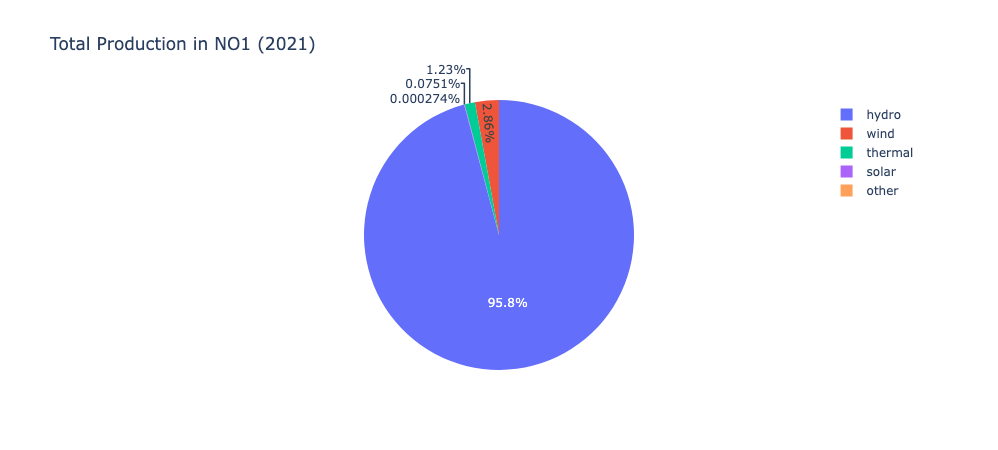

In [10]:
# Print Pie_chart.png, to show in pdf
display(Image(filename='Pie_chart.png'))

In [11]:
# Filter for January data
jan_df = selected_df.filter(
    (col("pricearea") == chosen_area) &
    (col("starttime").between("2021-01-01 00:00:00", "2021-01-31 23:59:59"))
)

# Aggregate daily production by production group
daily_prod = jan_df.withColumn("date", to_date("starttime")) \
    .groupBy("date", "productiongroup") \
    .agg(spark_sum("quantitykwh").alias("total_quantity")) \
    .orderBy("date")

pdf_daily = daily_prod.toPandas()

# Create line plot
fig_line = px.line(
    pdf_daily,
    x="date",
    y="total_quantity",
    color="productiongroup",
    title=f"Daily Production in {chosen_area} - January 2021",
    markers=True,
    labels={"total_quantity": "Total Quantity (kWh)", "date": "Date", "productiongroup": "Production Group"}
)
# Forcing the x-axis to show dates properly
fig_line.update_xaxes(tickformat="%b %d", hoverformat="%b %d")

fig_line.show()


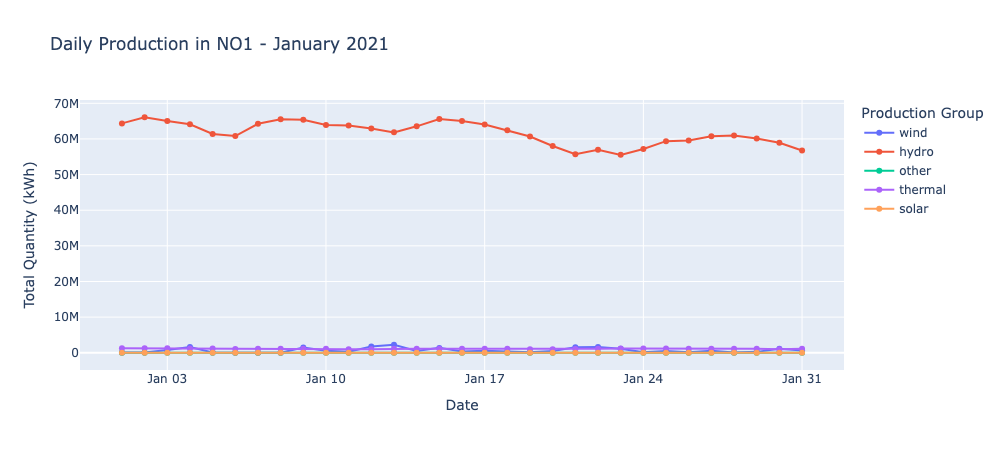

In [12]:
# Print Line_plot.png, to show in pdf
display(Image(filename='Line_plot.png'))


### Insert data into MongoDB

In [13]:
db = client["elhub_db"]
collection = db["production"]

# Convert Spark DataFrame to Pandas DataFrame
mongo_df = selected_df.toPandas()

# Insert into MongoDB
records = mongo_df.to_dict(orient='records')
result = collection.insert_many(records)
print(f"Inserted {len(result.inserted_ids)} documents into MongoDB")


Inserted 215353 documents into MongoDB
